### ML-based Factor Models for Foreign Exchange 
+ For each currency compute the following factors
    + SMA crossover
    + Momentum
    + Mean-Reversion
+ Compute daily, 5-day 10-day and 21-day returns on each currency pair
+ For OLS to get predicted returns
+ Rank the returns for each currency on each period
+ Go long the best performing and short the worst
+ For classification approach, encode the returns as positive or negative 


In [111]:
from math import floor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import TimeSeriesSplit


from sklearn import tree
import datetime as datetime


import quandl as ql
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import talib

from talib import MACD

%matplotlib inline
plt.style.use('seaborn')
# plt.rcParams['font.family'] = 'sans-serif'

In [2]:
ds_currency = xr.open_zarr('currency_pairs')

In [3]:
df_currency = ds_currency.to_dataframe().unstack(level=1)
df_currency.columns = df_currency.columns.droplevel(0)
df_currency = df_currency.rename_axis(None, axis=1)
df_currency.tail()


,aus_usd,cad_usd,eur_usd,jpy_usd,usd_gbp
Date,,,,,
2019-01-07,0.7143,1.3297,1.1468,108.62,1.2757
2019-01-08,0.7134,1.3307,1.1444,108.57,1.2724
2019-01-09,0.7172,1.3212,1.1524,108.38,1.2764
2019-01-10,0.7190,1.3232,1.1517,108.29,1.2768
2019-01-11,0.7204,1.3256,1.1479,108.34,1.2836


In [217]:
def compute_returns(period_df,period):
    '''
    Computes log returns for a pd.DataFrame of assets for a given period
    
    Parameters
    ==========
    period_df: pd.DataFrame
    period: int
    
    Returns
    =======
    pd.DataFrame with new column for log returns
    '''
    dfs = []
    df_cols = period_df.columns
    for col in df_cols:
        new_df = pd.DataFrame()
        new_df['{}_day_log_returns_{}'.format(period,col)] = np.log(period_df[col]/period_df[col].shift(period))
        dfs.append(new_df)
    ctd_df = pd.concat(dfs, axis=1)
    return ctd_df

def compute_moving_average_trend_signal(period_df,period_1, period_2):
    '''
    Computes moving averages used in ma crossover factor
    
    Parameters
    ==========
    period_df: pd.Dataframe
    period_1: int
    period_2: int
    
    Returns
    =======
    pd.Dataframe of price and moving averages for two specified periods 
    '''
    #dfs = []
    #for pair in period_df.columns:

    sma_period1 = period_df.rolling(period_1).mean() 

    sma_period2 = period_df.rolling(period_2).mean() 

    ma_signal = pd.Series(np.where(sma_period1 > sma_period2, 1, -1), index=period_df.index)
       # dfs.append(new_df)
#     ctd_df = pd.concat(dfs, axis=1)
    return ma_signal


def compute_macd_trend_confirm(df_currency, period_slow=26, period_fast=12):
    '''
    
    '''    
    p_slow = df_currency.ewm(adjust=True, span=period_slow).mean()
    p_fast = df_currency.ewm(adjust=True, span=period_fast).mean()
    
    MACD_line = p_fast - p_slow
    signal = MACD_line.ewm(adjust=True, span=9).mean()
    macd_factor = np.sign(MACD_line - signal)
    #macd_factor.columns = [pair + '_MACD' for pair in df_currency.columns]
    
    return macd_factor
    

def compute_reversal(period_df, period):
    '''
    This computes the mean reversion of a time series
    
    '''
    dfs = []
    for pair in period_df.columns:
        new_df = pd.DataFrame()
        mu = period_df[pair].rolling(period).mean()
        sigma = period_df[pair].std()
        new_df['reversal_{}'.format(pair)] = (period_df.shift(period) - mu)/sigma
        dfs.append(new_df)
    ctd_df = pd.concat(dfs, axis=1)
    ctd_df.index = period_df.index
    return ctd_df

def compute_momentum(period_df, threshold=0.02, period_string=None):
    '''
    This computes the momentum from the start to end period for a currency. 
    If period string is given, the data is resampled at that level and then 
    momentum is computed. 
    
    
    Parameters
    ==========
    period_df: pd.DataFrame
    lag_start: int from month
    lag_end: int from month
    period_string: values here `https://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases`
    
    Returns
    =======
    pd.DataFrame with new column for interval momentum
    
    
    '''
    deep_df = period_df.copy()
    if period_string:
        rsed = deep_df.resample(period_string).apply(lambda x: x[-1]) 
    else: rsed = deep_df
    rets = compute_returns(rsed, 1)
    cond = np.where(momentum_df >= threshold, 1, np.where(momentum_df <= -threshold, -1, 0))

    return pd.DataFrame(cond, columns=[pair+'_momentum' for pair in period_df.columns], index=rsed.index)


def compute_rate_of_change_indicator(df_currency, period=28):
    '''
    
    
    '''
    
    return np.sign(df_currency/df_currency.shift(period))
    
    

def compute_factors(df,pair, period):
    '''
    Computes momentum and mean reversal factors 
    as well as log returns for each currency pair and period
    
    Parameters
    ==========
    df: pd.Dataframe of date by currency price
    
    
    Returns
    =======
    tuple of monthly data, mu, sigma and factor and returns dataframe
    
    '''
    
    mu = df.mean()
    sigma = df.std()
    
    returns = np.log(df/df.shift(period))
    
    macd = compute_macd_trend_confirm(df)
    sma = compute_moving_average_trend_signal(df,42, 252)
    roc = compute_rate_of_change_indicator(df)
    
    ctd = pd.concat([macd,sma,roc, returns],axis=1)
#     ctd.columns  = ['macd', 'sma', 'roc', 'logged_returns']
#     ctd = ctd.dropna()
    
    return ctd


def compute_preds(clf, df, train_index, test_index, pair):
    '''
    Parameters
    ==========
    clf: sklearn classifier
    df: pd.Dataframe of period by currency_pair
    train_index: list of indices for training period
    test_index: list of indices for testing period
    pair: str of currency pair
    
    
    Returns
    =======
    dictionary of pd.Series of predicted returns and sklearn.LinearRegression fitted model
    
    
    '''

    X_train = df[:train_index[-1]][['macd', 'sma', 'roc']]
    X_test = df[train_index[-1]:][['macd', 'sma', 'roc']]
    y_train = np.sign(df[:train_index[-1]]['logged_returns'])
    y_test = np.sign(df[train_index[-1]:]['logged_returns'])
    
    
    model = clf()
    model.fit(X_train,y_train)
    model.predict(X_test)
    pred_returns = pd.Series(model.predict(X_test).flatten(), index=y_test.index, name=pair)
    
    return pred_returns
    
def generate_trades(predictions_df):
    '''
    Takes a dataframe of period returns by currency pair
    sorts them from highest to lowest and then assigns a value of 
    1/-1 to the highest/lowest values for each period. 
    
    Long/short positions are not required. If the worst performing of 
    the period is positive, only a long is taken. Similarly, if all 
    period returns were negative only the most negative receives is marked 
    -1, indicating a short position. 
    
    The trades are generated for the out of sample period. 
    
    Parameters
    ==========
    predictions_df: pd.DataFrame of period by currency pair 
    
    
    Returns
    =======
    pd.DataFrame of period by currency pair
    '''
    trades = []
    for i, row in predictions_df.iterrows():
        _sorted = row.sort_values(axis=0,ascending=False)
        #for condition that they the long is positive and the short is negative
        if _sorted[0]*_sorted[-1] < 0:
            trade = {_sorted.index[0]: 1,_sorted.index[-1]: -1}

        elif _sorted[0] and _sorted[-1] > 0:
            trade = {_sorted.index[0]: 1}

        else: 
            trade = {_sorted.index[-1]: -1}
        trades.append(trade)
        
    return pd.DataFrame(trades, index=predictions_df.index)

In [218]:

classifiers = [
    LogisticRegression(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    BernoulliNB(),
    ]
clf = AdaBoostClassifier()
tscv = TimeSeriesSplit(n_splits=10)
fold = 1
all_trades = []

for train_index, test_index in tscv.split(df_currency):
    pred_list = []
    for i in df_currency.columns:
        df = df_currency[i]
        #this is recomputing unnecessarily for each time step but whatever
        res = compute_factors(df, i, 21)
        #set up data
        #generate period/pair specific prediction
#         pred_list.append(compute_preds(clf, res, train_index, test_index, i))
#     #set up all pair predictions
#     preds = pd.concat(pred_list, axis =1)
#     #determine our trades
#     trades = generate_trades(preds)
#     all_trades.append(trades)

# trade_df = pd.concat(all_trades, axis=0)

#### Let's first compute the returns and do some basic EDA

In [23]:
#Compute the 21 day returns
currency_pair_21_day_returns = compute_returns(df_currency,21)

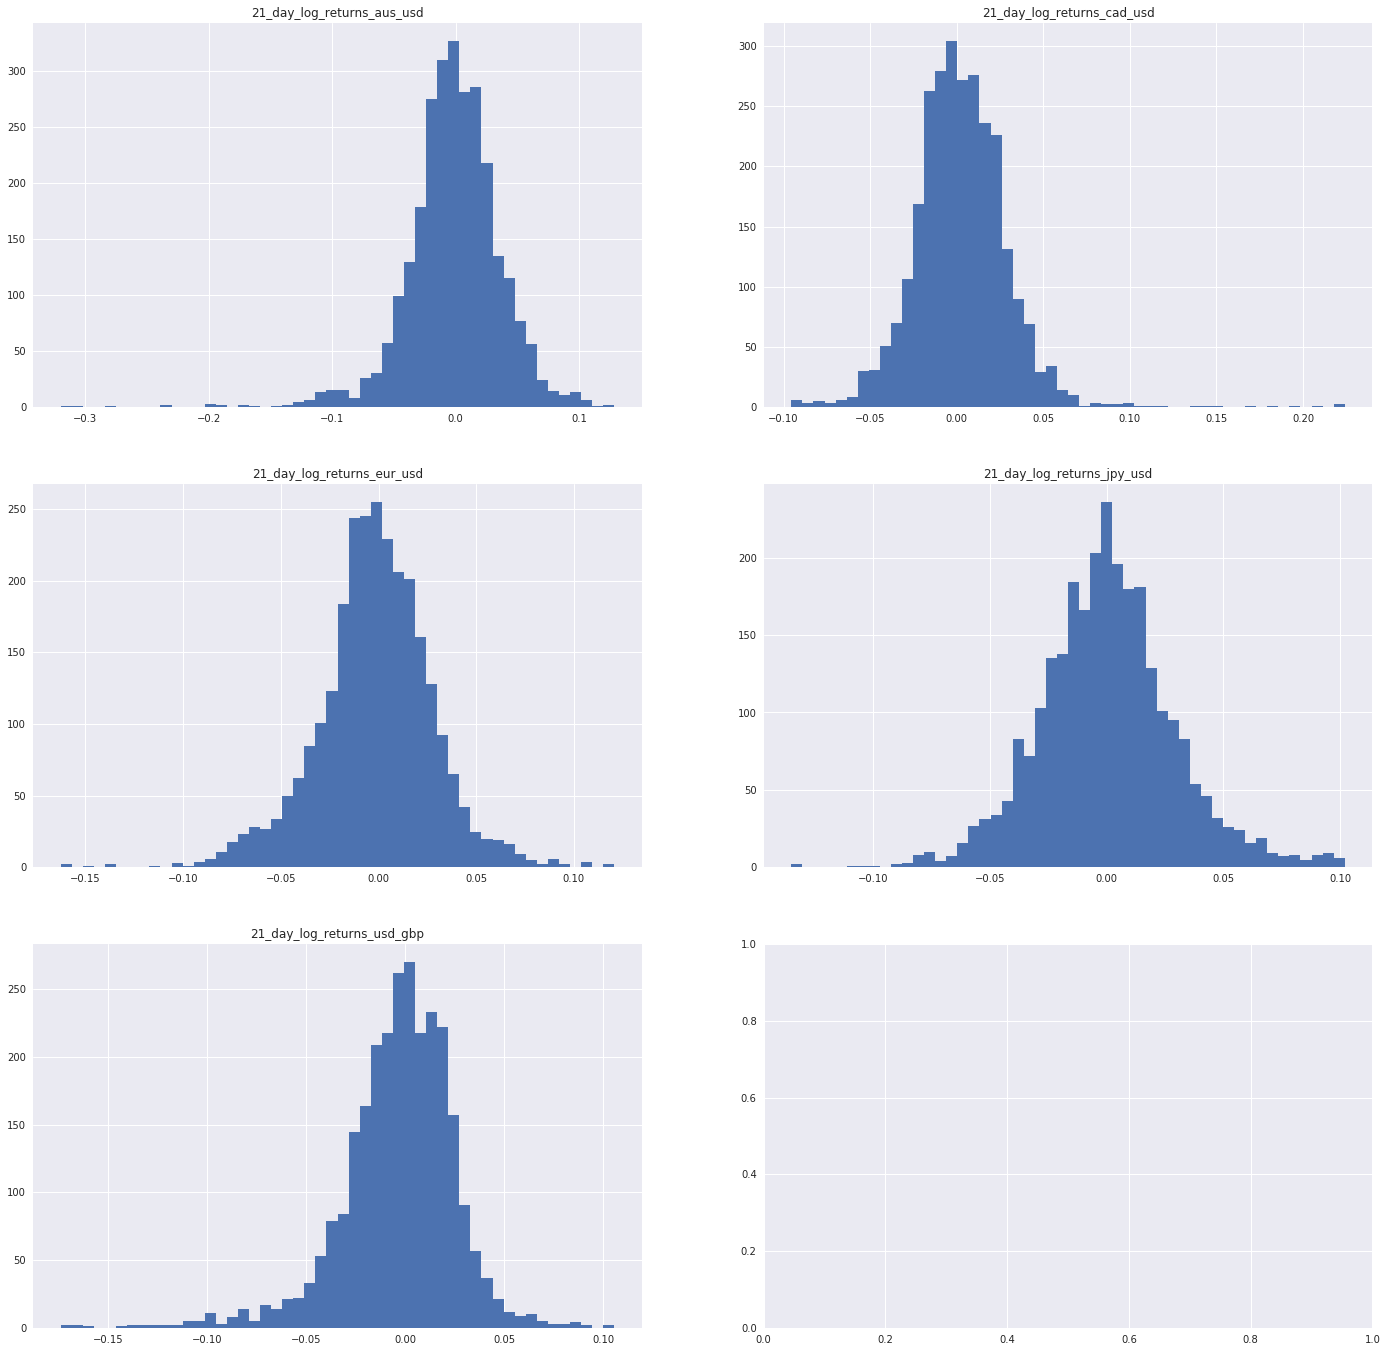

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(24, 24))

for i, pair in enumerate(ctd_df.columns):
    
    ctd_df['{}'.format(pair)].hist(bins=50, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title('{}'.format(pair))